In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import textwrap

from pydmd import DMD

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-11-02 08:29:18.733465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 08:29:18.949525: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 08:29:18.959550: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-02 08:29:18.959567: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

# Load Data

In [2]:
data_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT and ribosomal genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]
rp_genes = [x for x in all_genes if x.startswith('RP')]

print(f"{df.shape=}")
df = df.drop(mt_genes) # drop MT genes
df = df.drop(rp_genes) # drop ribosomal genes
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)
print(f"{gf.shape=}")


df.head()

df.shape=(19393, 18)
df.shape=(19235, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19235


/tmp/ipykernel_2936115/4036917658.py:23: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  gf = nb.getGeneLengths(gene_path, gene_names)


gf.shape=(19235, 2)


,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A1BG,12,5,5,9,2,6,7,3,6,5,5,5,4,3,4,5,5,3
A1CF,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,0,0,0
A2M,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,2
A2ML1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Choose Rank = 7; TPM > 0.5

In [3]:
target = 1e6
rank = 7
tpm = nb.TPM(df, gf, target=target)
nT = 7

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)

res = []

for threshold in np.linspace(0, 10, 10):

    # threshold genes
    mask = (tpm_dist > threshold)
    high_exp_genes = tpm_dist[mask].index.to_list()    

    print(f"{threshold=} {len(high_exp_genes)=}")

    # filter and convert to fold changes
    d = tpm[tpm.index.isin(high_exp_genes)]
    dmd_data = nb.data2DMD(d) 
    print(f"{dmd_data.shape=}")

    # perform DMD
    dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)

    # compute the Gram matrix
    A = dmd_res['Atilde']
    u = dmd_res['u_r']
    x0_embedded = dmd_res['data_embedded'][:,0,:]

    _, G = hasnain_DMD.gram_matrix(A, 
                                x0_embedded, 
                                nT=nT, 
                                reduced=True, 
                                projection_matrix=u)

    g_rank = np.linalg.matrix_rank(G)
    row = {
        'TPM threshold' : threshold,
        'n_genes' : G.shape[0],
        'Grank' : g_rank,
    }
    
    print(f"{G.shape=} {g_rank=}")
    res.append(row)

res = pd.DataFrame(res)
res.head()

threshold=0.0 len(high_exp_genes)=16224
dmd_data.shape=(16224, 8, 2)
G.shape=(16224, 16224) g_rank=7
threshold=1.1111111111111112 len(high_exp_genes)=6108
dmd_data.shape=(6108, 8, 2)
G.shape=(6108, 6108) g_rank=7
threshold=2.2222222222222223 len(high_exp_genes)=4240
dmd_data.shape=(4240, 8, 2)
G.shape=(4240, 4240) g_rank=7
threshold=3.3333333333333335 len(high_exp_genes)=3148
dmd_data.shape=(3148, 8, 2)
G.shape=(3148, 3148) g_rank=7
threshold=4.444444444444445 len(high_exp_genes)=2439
dmd_data.shape=(2439, 8, 2)
G.shape=(2439, 2439) g_rank=7
threshold=5.555555555555555 len(high_exp_genes)=1963
dmd_data.shape=(1963, 8, 2)
G.shape=(1963, 1963) g_rank=7
threshold=6.666666666666667 len(high_exp_genes)=1609
dmd_data.shape=(1609, 8, 2)
G.shape=(1609, 1609) g_rank=7
threshold=7.777777777777779 len(high_exp_genes)=1372
dmd_data.shape=(1372, 8, 2)
G.shape=(1372, 1372) g_rank=7
threshold=8.88888888888889 len(high_exp_genes)=1200
dmd_data.shape=(1200, 8, 2)
G.shape=(1200, 1200) g_rank=7
threshold

,TPM threshold,n_genes,Grank
0,0.000000,16224,7
1,1.111111,6108,7
2,2.222222,4240,7
3,3.333333,3148,7
4,4.444444,2439,7


<AxesSubplot: xlabel='TPM threshold', ylabel='Grank'>

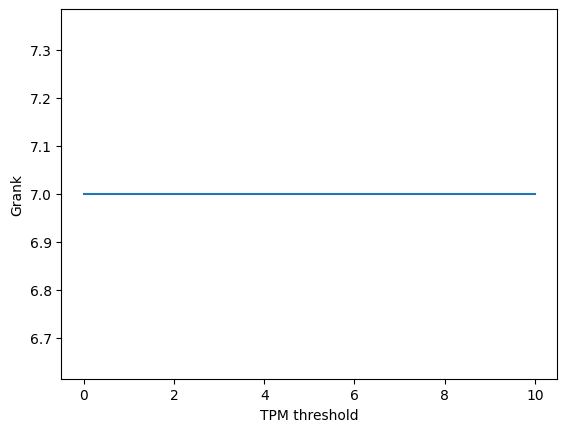

In [5]:
sns.lineplot(data=res, 
             x='TPM threshold',
             y='Grank')

In [4]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)